                                  Open         High          Low        Close  \
Date                                                                            
2024-01-02 00:00:00-05:00  4745.200195  4754.330078  4722.669922  4742.830078   
2024-01-03 00:00:00-05:00  4725.069824  4729.290039  4699.709961  4704.810059   
2024-01-04 00:00:00-05:00  4697.419922  4726.779785  4687.529785  4688.680176   
2024-01-05 00:00:00-05:00  4690.569824  4721.490234  4682.109863  4697.240234   
2024-01-08 00:00:00-05:00  4703.700195  4764.540039  4699.819824  4763.540039   

                               Volume  Dividends  Stock Splits  
Date                                                            
2024-01-02 00:00:00-05:00  3743050000        0.0           0.0  
2024-01-03 00:00:00-05:00  3950760000        0.0           0.0  
2024-01-04 00:00:00-05:00  3715480000        0.0           0.0  
2024-01-05 00:00:00-05:00  3844370000        0.0           0.0  
2024-01-08 00:00:00-05:00  3742320000     

C:\Users\jaros\AppData\Local\Temp\ipykernel_19412\72383584.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  month_starts = pd.to_datetime(data.index).to_period('M').drop_duplicates().to_timestamp()


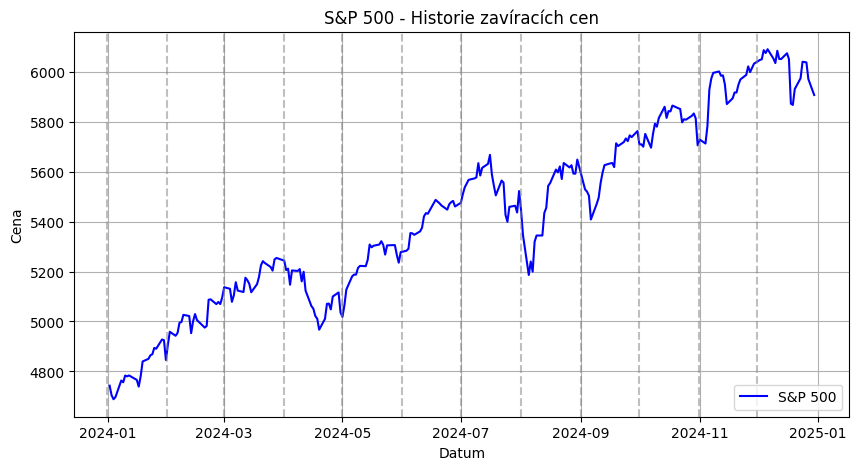

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ticker pro S&P 500
sp500 = yf.Ticker("^GSPC")

# Historická data za rok 2024
data = sp500.history(start="2024-01-01", end="2024-12-31")

# Výpis dat
print(data.head())

# Vykreslení grafu
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')

# Přidej svislé čáry na začátky měsíců
month_starts = pd.to_datetime(data.index).to_period('M').drop_duplicates().to_timestamp()
for date in month_starts:
    plt.axvline(date, color='gray', linestyle='--', alpha=0.5)

plt.title("S&P 500 - Historie zavíracích cen")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.grid(True)
plt.legend()
plt.show()

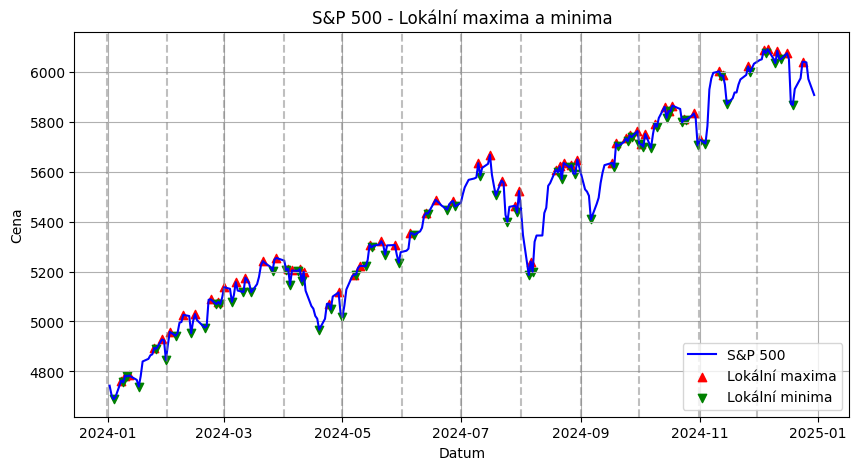

In [3]:
# najdi lokalní minima a maxima
def find_local_extrema(data):
    local_max = data[(data['Close'].shift(1) < data['Close']) & (data['Close'].shift(-1) < data['Close'])]
    local_min = data[(data['Close'].shift(1) > data['Close']) & (data['Close'].shift(-1) > data['Close'])]
    return local_max, local_min

local_max, local_min = find_local_extrema(data)

# Vykreslení grafu s lokálními extrémy
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')
plt.scatter(local_max.index, local_max['Close'], color='red', label='Lokální maxima', marker='^')
plt.scatter(local_min.index, local_min['Close'], color='green', label='Lokální minima', marker='v')
# Přidej svislé čáry na začátky měsíců
for date in month_starts:
    plt.axvline(date, color='gray', linestyle='--', alpha=0.5)
plt.title("S&P 500 - Lokální maxima a minima")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.grid(True)
plt.legend()
plt.show()

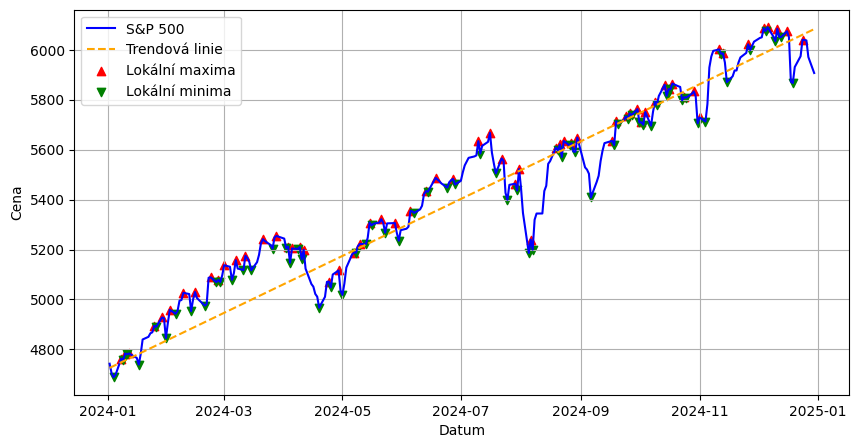

Koefficienty lineární regrese (m, b):
[ 3.73713453e+00 -2.75659401e+06]
Derivace trendové linie:
3.737134528881226


In [4]:
# metods: all, four_extrema

def linear_interpolate(data, local_max, local_min, method='four_extrema'):
    """
    Vytvoří trendovou linii pomocí lineární regrese na základě lokálních maxim a minim.
    Používá buď všechna lokální maxima a minima, nebo pouze čtyři extrémy (nejvyšší a nejnižší lokální maxima a minima).
    Metoda 'four_extrema':
        1. Najde největší a nejmenší lokální maxima a minima.
        2. Spočítá průměr z těchto hodnot.
        3. Data interpoluje přímkou mezi průměrnými hodnotami lokálních maxim a minim.
    """
    if method not in ['all', 'four_extrema']:
        raise ValueError("Invalid method. Use 'all' or 'four_extrema'.")
    
    if method == 'four_extrema':
        local_max_lowest = min(local_max['Close'])
        local_max_highest = max(local_max['Close'])
        local_min_lowest = min(local_min['Close'])
        local_min_highest = max(local_min['Close'])
        low_avg = np.mean([local_max_lowest, local_min_lowest])
        high_avg = np.mean([local_max_highest, local_min_highest])
        # Interpolace mezi průměrnými hodnotami lokálních maxim a minim
        x = np.array([data.index[0].toordinal(), data.index[-1].toordinal()])
        y = np.array([low_avg, high_avg])
    elif method == 'all':
        # Použij všechny lokální maxima a minima
        x = np.array([d.toordinal() for d in local_max.index] + [d.toordinal() for d in local_min.index])
        y = np.array(list(local_max['Close']) + list(local_min['Close']))
    
    coefficients = np.polyfit(x, y, 1)  # lineární regrese
    return coefficients

coefficients = linear_interpolate(data, local_max, local_min)

x_full = np.array([d.toordinal() for d in data.index])
trend_line = np.polyval(coefficients, x_full)

# zakresli v grafu trend
# spoj linií průmerné hodnoty lokálních maxim a minim
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')
plt.plot(data.index, trend_line, label="Trendová linie", color='orange', linestyle='--')
plt.scatter(local_max.index, local_max['Close'], color='red', label='Lokální maxima', marker='^')
plt.scatter(local_min.index, local_min['Close'], color='green', label='Lokální minima', marker='v')
# Přidej svislé čáry na začátky měsíců
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.grid(True)
plt.legend()
plt.show()


trend_derivative = coefficients[0]  # koeficient u x v lineární rovnici y = mx + b
print("Koefficienty lineární regrese (m, b):")
print(coefficients)

print("Derivace trendové linie:")
print(trend_derivative)

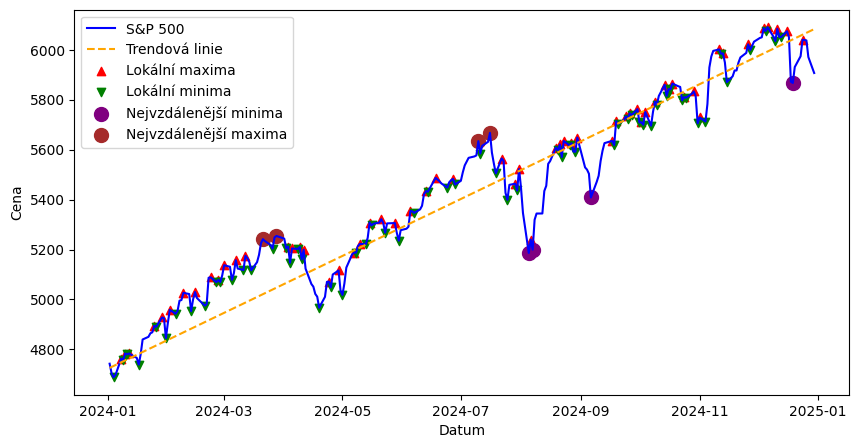

In [5]:
def find_farthest_negative_local_min(local_min, coefficients, n=1):
    """
    Najde n lokálních minim, které jsou nejvzdálenější od trendové linie směrem dolů.
    """
    x_ord = local_min.index.to_series().apply(lambda x: x.toordinal()).to_numpy(dtype=float)
    trend_vals = np.polyval(coefficients, x_ord)
    below_mask = local_min['Close'].values < trend_vals
    if not np.any(below_mask):
        raise ValueError("No local minima below the trend line.")
    distances = np.abs(local_min['Close'].values - trend_vals)
    filtered_distances = distances[below_mask]
    filtered_local_min = local_min.iloc[np.where(below_mask)[0]]
    # Najdi indexy n největších vzdáleností
    if n == 1:
        farthest_idx = np.argmax(filtered_distances)
        return filtered_local_min.iloc[farthest_idx]
    else:
        idxs = np.argsort(filtered_distances)[-n:][::-1]
        return filtered_local_min.iloc[idxs]

def find_farthest_positive_local_max(local_max, coefficients, n=1):
    """
    Najde n lokálních maxim, které jsou nejvzdálenější od trendové linie směrem nahoru.
    """
    x_ord = local_max.index.to_series().apply(lambda x: x.toordinal()).to_numpy(dtype=float)
    trend_vals = np.polyval(coefficients, x_ord)
    above_mask = local_max['Close'].values > trend_vals
    if not np.any(above_mask):
        raise ValueError("No local maxima above the trend line.")
    distances = np.abs(local_max['Close'].values - trend_vals)
    filtered_distances = distances[above_mask]
    filtered_local_max = local_max.iloc[np.where(above_mask)[0]]
    # Najdi indexy n největších vzdáleností
    if n == 1:
        farthest_idx = np.argmax(filtered_distances)
        return filtered_local_max.iloc[farthest_idx]
    else:
        idxs = np.argsort(filtered_distances)[-n:][::-1]
        return filtered_local_max.iloc[idxs]
    

n_extrema = 4
farthest_local_min = find_farthest_negative_local_min(local_min, coefficients, n=n_extrema)
farthest_local_max = find_farthest_positive_local_max(local_max, coefficients, n=n_extrema)

# plot trend line with farthest local minima/maxima
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')
plt.plot(data.index, trend_line, label="Trendová linie", color='orange', linestyle='--')
plt.scatter(local_max.index, local_max['Close'], color='red', label='Lokální maxima', marker='^')
plt.scatter(local_min.index, local_min['Close'], color='green', label='Lokální minima', marker='v')

# vykresli všechna n extrémů
if n_extrema == 1:
    plt.scatter(farthest_local_min.name, farthest_local_min['Close'], color='purple', label='Nejvzdálenější lokální minimum', marker='o', s=100)
    plt.scatter(farthest_local_max.name, farthest_local_max['Close'], color='brown', label='Nejvzdálenější lokální maximum', marker='o', s=100)
else:
    plt.scatter(farthest_local_min.index, farthest_local_min['Close'], color='purple', label='Nejvzdálenější minima', marker='o', s=100)
    plt.scatter(farthest_local_max.index, farthest_local_max['Close'], color='brown', label='Nejvzdálenější maxima', marker='o', s=100)

plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.show()

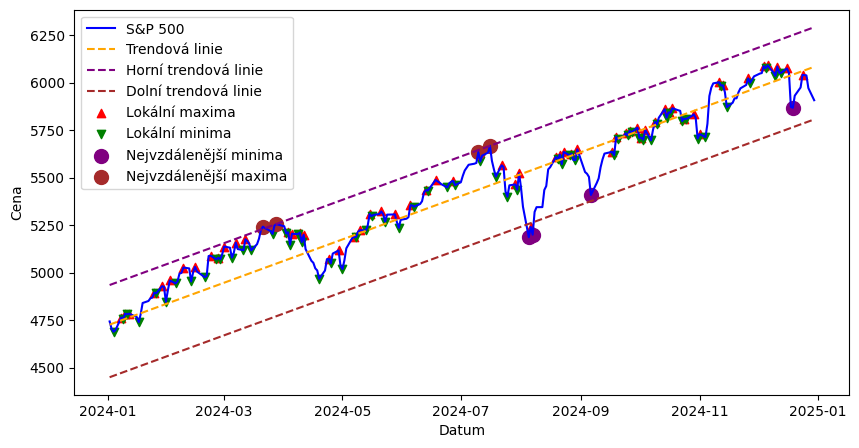

In [6]:
# vyber průmerné hodnoty farthest_local_min
# spocitej vzdálenost od trendové linie
# vytvoř horní a dolní trendovou linii
# vykresli je

def create_affine_trend_lines(data, extrems, coefficients):
    """
    Spočte vzdálenosti extrémů od trendové linie
    Vypočte prumernou hodnotu vzdáleností
    Použije ji jako offset pro vytvoření nové trendové linie.
    """
    # Najdi pozice extrémů v rámci hlavního indexu data
    data_idx = pd.Series(range(len(data)), index=data.index)
    extrems_pos = data_idx[extrems.index].values
    x_ord = data.index.to_series().apply(lambda x: x.toordinal()).to_numpy(dtype=float)
    trend_vals = np.polyval(coefficients, x_ord)
    # Vzdálenosti pouze v bodech extrémů
    distances = extrems['Close'].values - trend_vals[extrems_pos]
    avg_distance = np.mean(distances)
    # Offset podle směru (pro horní/dolní linii) a dosadí do trendové linie
    new_coefficients = coefficients.copy()
    new_coefficients[1] += avg_distance
    return new_coefficients

upper_trend_line = create_affine_trend_lines(data, farthest_local_max, coefficients)
lower_trend_line = create_affine_trend_lines(data, farthest_local_min, coefficients)

# Vykreslení horní a dolní trendové linie
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')
plt.plot(data.index, trend_line, label="Trendová linie", color='orange', linestyle='--')
plt.plot(data.index, np.polyval(upper_trend_line, x_full), label="Horní trendová linie", color='purple', linestyle='--')
plt.plot(data.index, np.polyval(lower_trend_line, x_full), label="Dolní trendová linie", color='brown', linestyle='--')
plt.scatter(local_max.index, local_max['Close'], color='red', label='Lokální maxima', marker='^')
plt.scatter(local_min.index, local_min['Close'], color='green', label='Lokální minima', marker='v')
plt.scatter(farthest_local_min.index, farthest_local_min['Close'], color='purple', label='Nejvzdálenější minima', marker='o', s=100)
plt.scatter(farthest_local_max.index, farthest_local_max['Close'], color='brown', label='Nejvzdálenější maxima', marker='o', s=100)
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.show()

Price 5433.740234375 is in upper band at 2024-06-13 00:00:00-04:00
Price 5431.60009765625 is in upper band at 2024-06-14 00:00:00-04:00
Price 5473.22998046875 is in upper band at 2024-06-17 00:00:00-04:00
Price 5487.02978515625 is in upper band at 2024-06-18 00:00:00-04:00
Price 5473.169921875 is in upper band at 2024-06-20 00:00:00-04:00
Price 5464.6201171875 is in upper band at 2024-06-21 00:00:00-04:00
Open trade: decline at 5447.8701171875 on date 2024-06-24 00:00:00-04:00
Price 5477.89990234375 is in upper band at 2024-06-26 00:00:00-04:00
Price 5482.8701171875 is in upper band at 2024-06-27 00:00:00-04:00
Price 5509.009765625 is in upper band at 2024-07-02 00:00:00-04:00
Price 5537.02001953125 is in upper band at 2024-07-03 00:00:00-04:00
Price 5567.18994140625 is in upper band at 2024-07-05 00:00:00-04:00
Price 5572.85009765625 is in upper band at 2024-07-08 00:00:00-04:00
Price 5576.97998046875 is in upper band at 2024-07-09 00:00:00-04:00
Price 5584.5400390625 is in upper band

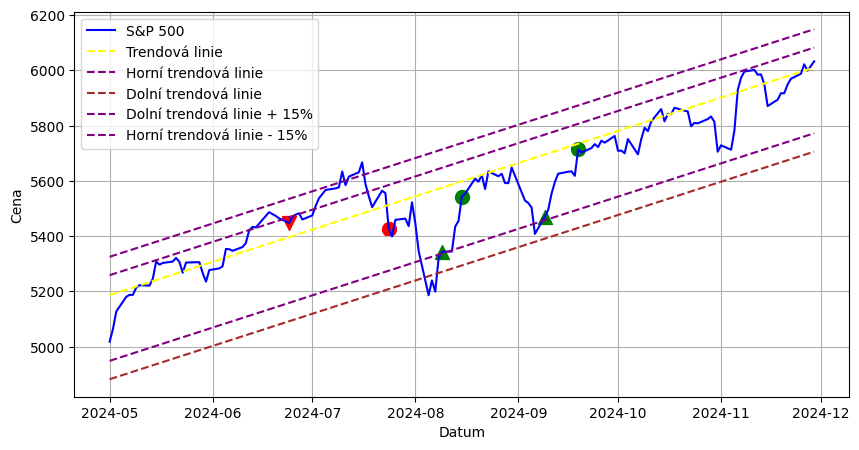

In [15]:
# 15% od okraje kanálů
# držíme do 50% šířky kanálu
# vs držíme do změny na 60%


def affine_shift(coefficients, shift):
    """
    Vytvoří novou trendovou linii posunutou o daný offset.
    """
    new_coefficients = coefficients.copy()
    new_coefficients[1] += shift
    return new_coefficients

def parallel_lines_delta(parallel1, parallel2):
    """
    Vypočítá vzdálenost mezi dvěma rovnoběžnými liniemi.
    """
    if len(parallel1) != len(parallel2):
        raise ValueError("Both lines must have the same number of coefficients.")
    return abs(parallel1[1] - parallel2[1])

class Trade:
    def __init__(self, entry_price, entry_date, criterial_func, trade_type='growth'):
        """
        Inicializuje obchod s cenou vstupu, datem vstupu a cenou k zastavení.
        type: 'growth' pro růstový obchod, 'decline' pro poklesový obchod.
        """
        self.entry_price = entry_price
        self.entry_date = entry_date
        self.trade_type = trade_type
        self.criterial_func = criterial_func  # funkce pro kontrolu uzavření obchodu

    def close_trade(self, exit_price, exit_date):
        if hasattr(self, 'exit_price') or hasattr(self, 'exit_date'):
            raise ValueError("Trade is already closed.")
        self.exit_price = exit_price
        self.exit_date = exit_date

    def is_closed(self):
        return hasattr(self, 'exit_price') and hasattr(self, 'exit_date')
    
    def check_for_close(self, price, date):
        """
        Kontroluje, zda by měla být obchod uzavřen na základě aktuální ceny a data.
        Pokud je cena nižší než cena k zastavení, obchod se uzavře.
        """
        if not self.is_closed():
            if (self.trade_type == 'growth' and price > self.criterial_func(date.toordinal())):
                self.close_trade(price, date)
                return True
            elif (self.trade_type == 'decline' and price < self.criterial_func(date.toordinal())):
                self.close_trade(price, date)
                return True
        return False

    def profit(self):
        """
        Vypočítá zisk z obchodu.
        Pokud obchod není uzavřen, vrátí None.
        """
        if not self.is_closed():
            return None
        return self.exit_price - self.entry_price if self.trade_type == 'growth' else self.entry_price - self.exit_price

def make_crit_func(coefficients_trend_line, trend_width, delta_percentage, trade_type):
    """
    Vytvoří funkci pro kontrolu uzavření obchodu na základě trendové linie a procentuálního posunu.
    """
    def func(x):
        if trade_type == 'growth':
            return np.polyval(coefficients_trend_line, x) + delta_percentage * trend_width
        elif trade_type == 'decline':
            return np.polyval(coefficients_trend_line, x) - delta_percentage * trend_width
        else:
            raise ValueError("Invalid trade type. Use 'growth' or 'decline'.")
    return func

def coef_to_func(coefficients):
    """
    Vytvoří funkci z koeficientů lineární regrese.
    """
    def func(x):
        return np.polyval(coefficients, x)
    return func

def coef_to_value(coefficients, x):
    """
    Vypočítá hodnotu funkce z koeficientů lineární regrese pro daný x.
    """
    return np.polyval(coefficients, x)

def price_is_in_band(price, i, lower_trend_coef, upper_trend_coef):
    """
    Zjistí, zda je cena v pásmu mezi dolní a horní trendovou linií.
    Pokud jsou oba koeficienty stejné, testuje pouze rovnost.
    """
    lower = coef_to_value(lower_trend_coef, x_full[i])
    upper = coef_to_value(upper_trend_coef, x_full[i])
    if lower == upper:
        return np.isclose(price, lower)
    return min(lower, upper) <= price <= max(lower, upper)


# omezení 5-11 mesíce
data = data.loc['2024-05-01':'2024-11-30']

local_max, local_min = find_local_extrema(data)
coefficients = linear_interpolate(data, local_max, local_min)
n_extrema = 4
farthest_local_min = find_farthest_negative_local_min(local_min, coefficients, n=n_extrema)
farthest_local_max = find_farthest_positive_local_max(local_max, coefficients, n=n_extrema)
upper_trend_line = create_affine_trend_lines(data, farthest_local_max, coefficients)
lower_trend_line = create_affine_trend_lines(data, farthest_local_min, coefficients)

x_full = np.array([d.toordinal() for d in data.index])
trend_line = np.polyval(coefficients, x_full)

trend_width = parallel_lines_delta(upper_trend_line, lower_trend_line)
upper_trend_line_15 = affine_shift(upper_trend_line, -0.15 * trend_width)
lower_trend_line_15 = affine_shift(lower_trend_line, 0.15 * trend_width)

data_close = data['Close']

open_trade = None
close_trades = []
price_delta = 50/100
open_condition = 'on_entry'
open_condition = 'on_exit'
last_was_in_band = False # poslední hodnta byla v pásmu 15% od horní nebo dolní linie

for i in range(len(data)):
    # Otevření obchodu
    price = data_close.iloc[i]
    
    is_in_upper_band = price_is_in_band(price, i, upper_trend_line_15, upper_trend_line)
    is_in_lower_band = price_is_in_band(price, i, lower_trend_line, lower_trend_line_15)
    if open_trade is None:
        if open_condition == 'on_entry':
            if price_is_in_band(price, i, lower_trend_line, lower_trend_line_15):
                crit = make_crit_func(lower_trend_line, trend_width, price_delta, 'growth')
                open_trade = Trade(data_close.iloc[i], data.index[i], crit, trade_type='growth')
                print(f"Open trade: {open_trade.trade_type} at {open_trade.entry_price} on date {open_trade.entry_date}")
            elif price_is_in_band(price, i, upper_trend_line_15, upper_trend_line):
                crit = make_crit_func(upper_trend_line, trend_width, price_delta, 'decline')
                open_trade = Trade(data_close.iloc[i], data.index[i], crit, trade_type='decline')
                print(f"Open trade: {open_trade.trade_type} at {open_trade.entry_price} on date {open_trade.entry_date}")
        
        elif open_condition == 'on_exit':
            # pokud poslední hodnota byla v pásmu horní linie, ale není v pásmu horní linie, otevři obchod na pokles
            if last_was_in_band == "upper" and not is_in_upper_band:
                crit = make_crit_func(upper_trend_line, trend_width, price_delta, 'decline')
                open_trade = Trade(data_close.iloc[i], data.index[i], crit, trade_type='decline')
                print(f"Open trade: {open_trade.trade_type} at {open_trade.entry_price} on date {open_trade.entry_date}")
            # pokud poslední hodnota byla v pásmu dolní linie, ale není v pásmu dolní linie, otevři obchod na růst
            elif last_was_in_band == "lower" and not is_in_lower_band:
                crit = make_crit_func(lower_trend_line, trend_width, price_delta, 'growth')
                open_trade = Trade(data_close.iloc[i], data.index[i], crit, trade_type='growth')
                print(f"Open trade: {open_trade.trade_type} at {open_trade.entry_price} on date {open_trade.entry_date}")
                

    # price je v pásmu 15% od horní linie
    if is_in_upper_band:
        last_was_in_band = "upper"
        print(f"Price {price} is in upper band at {data.index[i]}")
    elif is_in_lower_band:
        last_was_in_band = "lower"
    else:
        last_was_in_band = False

    # Kontrola uzavření obchodu
    if open_trade is not None:
        if open_trade.check_for_close(data_close.iloc[i], data.index[i]):
            close_trades.append(open_trade)
            open_trade = None

# uzavření otevřeného obchodu, pokud existuje
if open_trade is not None:
    open_trade.close_trade(data_close.iloc[-1], data.index[-1])
    close_trades.append(open_trade)

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'], label="S&P 500", color='blue')
plt.plot(data.index, trend_line, label="Trendová linie", color='yellow', linestyle='--')
plt.plot(data.index, np.polyval(upper_trend_line, x_full), label="Horní trendová linie", color='purple', linestyle='--')
plt.plot(data.index, np.polyval(lower_trend_line, x_full), label="Dolní trendová linie", color='brown', linestyle='--')
plt.plot(data.index, np.polyval(lower_trend_line_15, x_full), label="Dolní trendová linie + 15%", color='purple', linestyle='--')
plt.plot(data.index, np.polyval(upper_trend_line_15, x_full), label="Horní trendová linie - 15%", color='purple', linestyle='--')
plt.grid(True)
plt.legend()

# Vykreslení obchodů
for trade in close_trades:
    if trade.trade_type == 'growth':
        plt.scatter(trade.entry_date, trade.entry_price, color='green', marker='^', s=100, label='Růstový obchod')
        plt.scatter(trade.exit_date, trade.exit_price, color='green', marker='o', s=100)
    elif trade.trade_type == 'decline':
        plt.scatter(trade.entry_date, trade.entry_price, color='red', marker='v', s=100, label='Poklesový obchod')
        plt.scatter(trade.exit_date, trade.exit_price, color='red', marker='o', s=100)
plt.xlabel("Datum")
plt.ylabel("Cena")

profit = [] 
profit_trades = 0
for trade in close_trades:
    profit.append(trade.profit())
    if trade.profit() > 0:
        profit_trades += 1
    print(f"Trade from {trade.entry_date} to {trade.exit_date}: Profit = {trade.profit()}")

print(f"Total profit from all trades: {sum(profit)}")
print(f"Number of profitable trades: {profit_trades} out of {len(close_trades)}")
plt.show()